# Notebook for making graphs and getting data for a meeting with PJP

2021-07-27

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io
from src.loggers import logger, set_console_handler_level
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.modeling import simulation_based_calibration_helpers as sbc
from src.models.speclet_two import SpecletTwo
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARNING)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

In [5]:
scratch_dir_path = Path("/n/scratch3/users/j/jc604/")
sbc_perm_root_dir = scratch_dir_path / "speclet-sbc" / "sp2-default_MCMC"
list(sbc_perm_root_dir.iterdir())[:5]

[PosixPath('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm0'),
 PosixPath('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm1'),
 PosixPath('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm10'),
 PosixPath('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm100'),
 PosixPath('/n/scratch3/users/j/jc604/speclet-sbc/sp2-default_MCMC/sbc-perm101')]

In [6]:
sbc_fm = sbc.SBCFileManager(sbc_perm_root_dir / "sbc-perm435")
sbc_data = sbc_fm.get_sbc_data()
sbc_res = sbc_fm.get_sbc_results()

In [7]:
sbc_data.head()

,Unnamed: 0,depmap_id,hugo_symbol,lineage,p_dna_batch,screen,sgrna_target_chr,sgrna,copy_number,rna_expr,is_mutated,lfc
0,0,cellline2,gene0,lineage0,batch2,broad,Chr2,gene0_sgrna0,1.037115,11.477938,False,-0.814870
1,1,cellline2,gene0,lineage0,batch2,broad,Chr2,gene0_sgrna1,1.037115,11.477938,False,-0.991025
2,2,cellline2,gene0,lineage0,batch2,broad,Chr2,gene0_sgrna2,1.037115,11.477938,False,-1.015043
3,3,cellline2,gene0,lineage0,batch2,broad,Chr2,gene0_sgrna3,1.037115,11.477938,False,-0.619699
4,4,cellline2,gene0,lineage0,batch2,broad,Chr2,gene0_sgrna4,1.037115,11.477938,False,-1.134367


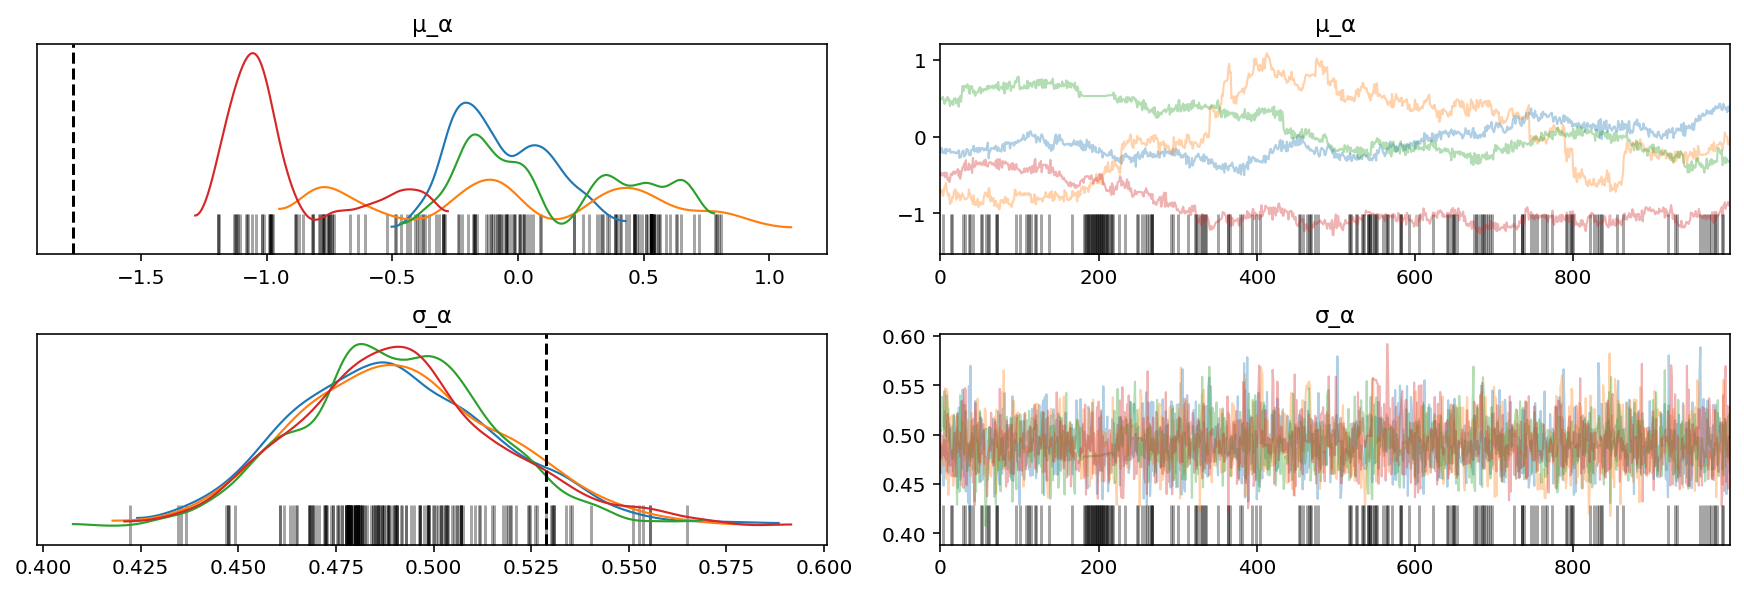

In [9]:
var_names = ["μ_α", "σ_α"]
known_values = [sbc_res.priors[v][0] for v in var_names]
axes = az.plot_trace(sbc_res.inference_obj, var_names=var_names, compact=False)

for val, ax in zip(known_values, axes[:, 0]):
    ax.axvline(val, color="k", linestyle="--")

plt.show()

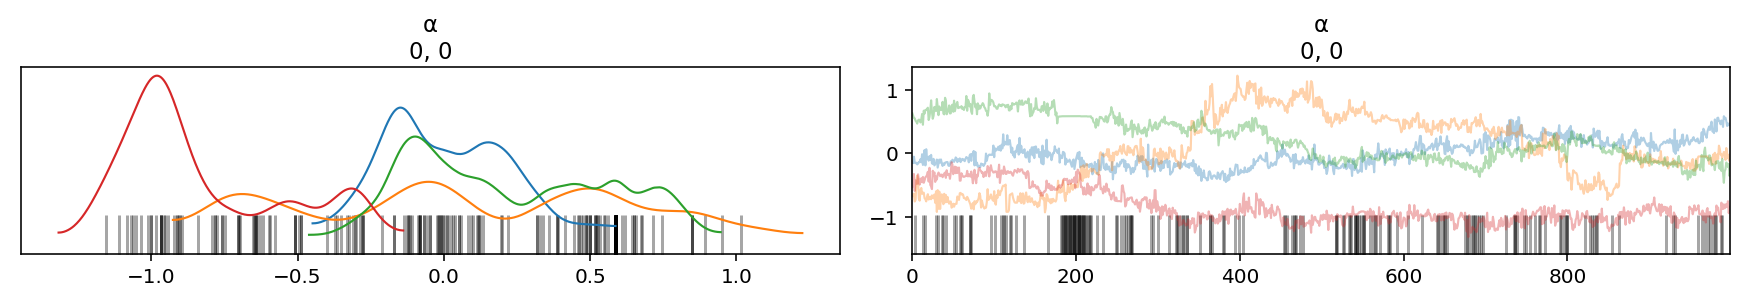

In [10]:
az.plot_trace(
    sbc_res.inference_obj,
    var_names="α",
    coords={"α_dim_0": [0], "α_dim_1": [0]},
    compact=False,
);

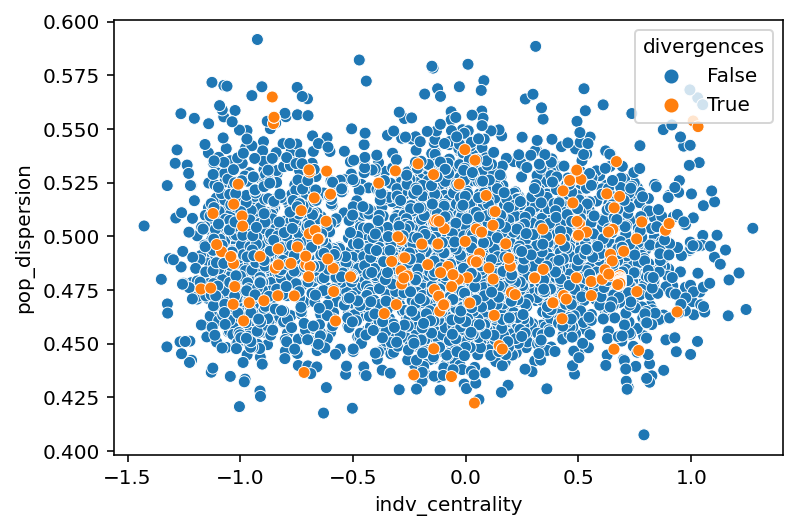

In [11]:
pop_dispersion = sbc_res.inference_obj["posterior"]["σ_α"].values
indv_centrality = sbc_res.inference_obj["posterior"]["α"][:, :, 1, 1].values.squeeze()
divergences = pmanal.get_divergences(sbc_res.inference_obj)

df = pd.DataFrame(
    {
        "pop_dispersion": pop_dispersion.flatten(),
        "log_pop_dispersion": np.log(pop_dispersion.flatten()),
        "indv_centrality": indv_centrality.flatten(),
        "divergences": divergences.flatten(),
    }
).sort_values("divergences")

sns.scatterplot(data=df, x="indv_centrality", y="pop_dispersion", hue="divergences");

In [12]:
sp2 = SpecletTwo("exmaple-model", Path("temp"), debug=True)
sp2.data_manager.set_data(sbc_data)
sp2.build_model()

[07/27/21 12:22:58] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1627402978.133217-510036;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:265
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1627402978.139541-430722;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:275
                             copy number.

In [13]:
with sp2.model:
    prior_pred = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

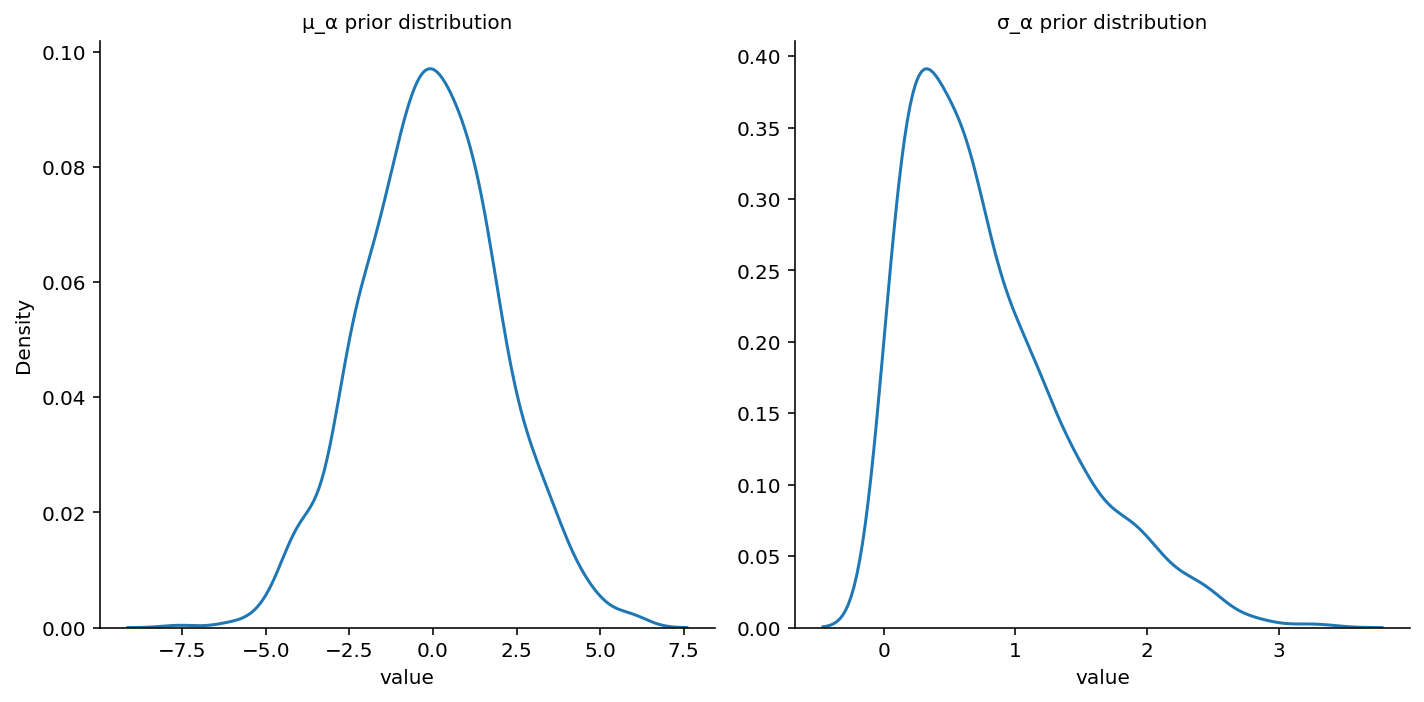

In [14]:
priors_df = pd.DataFrame(
    {"μ_α": prior_pred["μ_α"], "σ_α": prior_pred["σ_α"]}
).pivot_longer()
priors_df.head()
g = sns.displot(
    priors_df,
    x="value",
    col="variable",
    kind="kde",
    facet_kws={"sharex": False, "sharey": False},
)
g.set_titles("{col_name} prior distribution")
plt.show()

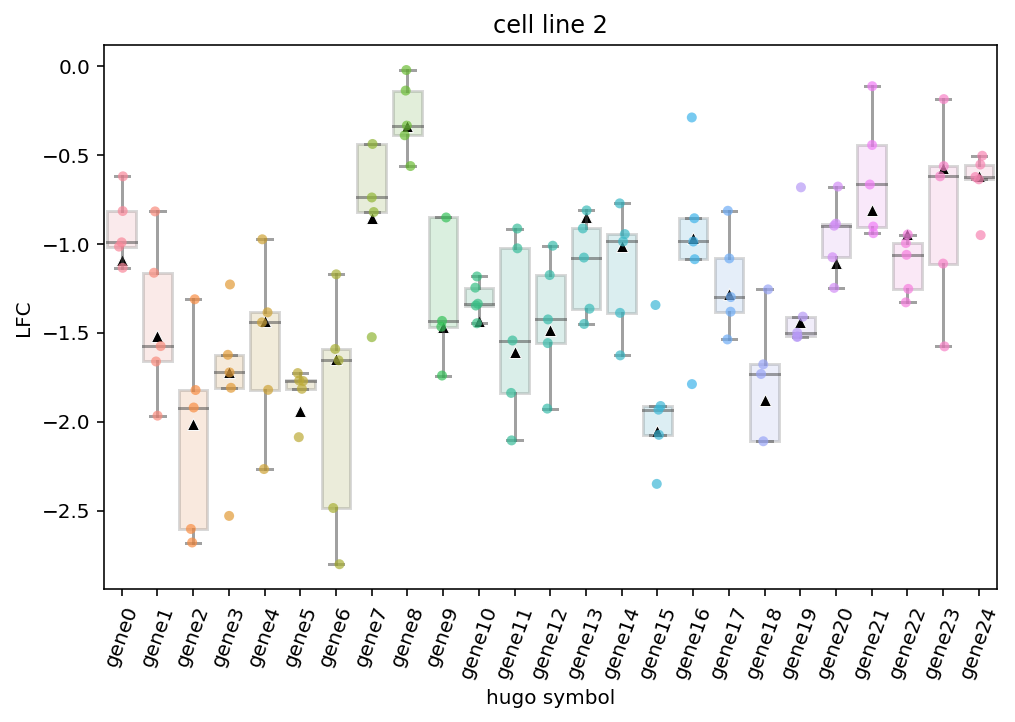

In [15]:
df = sbc_data.copy().query("depmap_id == 'cellline2'")
df["μ"] = sbc_res.priors["μ"].squeeze()[df.index.values]


plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    data=df,
    x="hugo_symbol",
    y="lfc",
    showfliers=False,
    boxprops={"alpha": 0.2},
    medianprops={"alpha": 0.5},
    whiskerprops={"alpha": 0.5},
    capprops={"alpha": 0.5},
)
sns.stripplot(data=df, x="hugo_symbol", y="lfc", alpha=0.7, ax=ax)
sns.scatterplot(
    data=df[["hugo_symbol", "μ"]].drop_duplicates(),
    x="hugo_symbol",
    y="μ",
    color="k",
    marker="^",
    ax=ax,
)

plt.xticks(rotation=70)
ax.set_title("cell line 2")
ax.set_xlabel("hugo symbol")
ax.set_ylabel("LFC")

plt.show()

---

In [16]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.74 minutes


In [17]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-27

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-55.o2.rc.hms.harvard.edu

Git branch: sbc-uniform-check

arviz     : 0.11.2
theano    : 1.0.5
pymc3     : 3.11.1
plotnine  : 0.7.1
re        : 2.2.1
matplotlib: 3.3.4
seaborn   : 0.11.1
logging   : 0.5.1.2
janitor   : 0.20.14
pandas    : 1.2.3
numpy     : 1.20.1

